# Required libraries

In [1]:
# Required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
# Import DBSCAN
from hana_ml.algorithms.pal.clustering import DBSCAN

# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one



# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_ANOMALY_DATA_DBSCAN" # Changed table name for DBSCAN
# Path to the generated data file
CSV_FILENAME = 'synthetic_anomaly_data.csv'
# Unique identifier column for HANA PAL functions
KEY_COL = 'ID'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'

ImportError: cannot import name 'display' from 'IPython.core.display' (/Users/I760054/Documents/programs/Best Practices/sap-btp-ai-best-practices/.venv/lib/python3.12/site-packages/IPython/core/display.py)


HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# DBSCAN with hana-ml

**Objective:** This notebook demonstrates how to use the `DBSCAN` algorithm provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client. We will perform anomaly detection on a synthetically generated dataset.

**Algorithm Overview:**
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. It groups together points that are closely packed together (having many neighbors within a certain distance) and marks points that lie alone in low-density regions as outliers. It can discover clusters of arbitrary shape and is robust to noise.

The algorithm classifies points into three types:
*   **Core point:** A point that has at least `minpts` (minimum points) within a distance of `eps` (epsilon) from itself.
*   **Border point:** A point that has fewer than `minpts` neighbors within `eps`, but is reachable from a core point.
*   **Noise point:** A point that is neither a core point nor a border point. These are considered outliers.

**`hana_ml` Implementation:**
The `hana_ml.algorithms.pal.clustering.DBSCAN` class provides an interface to the PAL DBSCAN function (more documentation available [here](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.07/en-US/pal/algorithms/hana_ml.algorithms.pal.clustering.DBSCAN.html#hana_ml.algorithms.pal.clustering.DBSCAN)).

**Key Parameters (`DBSCAN` constructor):**

*   `minpts` (int, optional): The minimum number of points required to form a cluster. If `None`, automatically determined.
*   `eps` (float, optional): The maximum distance between two samples for one to be considered as in the neighborhood of the other. If `None`, automatically determined.
    *   **Note:** `minpts` and `eps` must be provided together or both left as `None` for automatic determination.
*   `thread_ratio` (float, optional, default=heuristically determined): Controls the percentage of available CPU threads PAL can use (0.0 to 1.0). 0 means single-threaded, 1 means use all available threads. Values outside the range are ignored.
*   `metric` ({'manhattan', 'euclidean', 'minkowski', 'chebyshev', 'standardized_euclidean', 'cosine'}, optional, default='euclidean'): Distance metric to use.
*   `minkowski_power` (int, optional, default=3): The power parameter for the Minkowski metric. Only applicable when `metric` is 'minkowski'.
*   `categorical_variable` (str or a list of str, optional): Specifies which INTEGER columns should be treated as categorical.
*   `category_weights` (float, optional, default=0.707): The weight of category attributes.
*   `algorithm` ({'brute-force', 'kd-tree'}, optional, default='kd-tree'): Method to search for neighboring points.
*   `save_model` (bool, optional, default=True): If `True`, the model will be saved internally, which is required to use the `predict()` method.

## 1. Data Loading and Preparation

First, we load the synthetic data generated by `anomaly_generator.py` into a pandas DataFrame and then upload it to SAP HANA.

In [2]:
# Load data from CSV
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please run the 'anomaly_generator.py' script first to create the data.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# Add a unique ID column required by many PAL functions
if KEY_COL not in df_local.columns:
    df_local.insert(0, KEY_COL, range(len(df_local)))
    print(f"Added unique '{KEY_COL}' column.")

# Identify feature columns (assuming they start with 'feature_')
feature_cols = [col for col in df_local.columns if col.startswith('feature_')]
if not feature_cols:
     raise ValueError("No columns starting with 'feature_' found. Check data generation script or naming.")
print(f"Identified Feature Columns: {feature_cols}")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))

# Calculate the actual contamination level from the ground truth (for evaluation later)
actual_contamination = df_local[TRUTH_COL].mean()
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")

# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}' (if any).")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    # Using force=True and replace=True ensures the table matches the pandas DF exactly
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key=KEY_COL # Setting primary key can improve performance
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.select(KEY_COL).count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select(KEY_COL, TRUTH_COL, *feature_cols).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_anomaly_data.csv' with shape (1050, 6)
Added unique 'ID' column.
Identified Feature Columns: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1050 non-null   int64  
 1   feature_1   1050 non-null   float64
 2   feature_2   1050 non-null   float64
 3   feature_3   1050 non-null   float64
 4   feature_4   1050 non-null   float64
 5   feature_5   1050 non-null   float64
 6   is_anomaly  1050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 57.6 KB

Local DataFrame Head:
   ID  feature_1  feature_2  feature_3  feature_4  feature_5  is_anomaly
0   0  18.277572  48.592749  43.922557  42.893798  13.340332           0
1   1  22.595480  45.241644  34.772461  29.038658  15.248534           0
2   2  20.127974  4

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_ANOMALY_DATA_DBSCAN: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_ANOMALY_DATA_DBSCAN' (if any).

Uploading data to HANA table 'SYNTHETIC_ANOMALY_DATA_DBSCAN'...


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Successfully created HANA DataFrame: 1050 rows.

HANA DataFrame Info (selected columns):
   ID  is_anomaly  feature_1  feature_2  feature_3  feature_4  feature_5
0   0           0  18.277572  48.592749  43.922557  42.893798  13.340332
1   1           0  22.595480  45.241644  34.772461  29.038658  15.248534
2   2           0  20.127974  48.403411  23.545939  33.311360  -2.885488
3   3           0  16.412641  45.087063  47.438820  31.308031  26.548545
4   4           0  17.728823  47.785572  29.888634  17.650589  -1.527156


## 2. Training the DBSCAN Model

Now, we instantiate the `DBSCAN` class from `hana-ml` and train it using the `fit()` method on our HANA DataFrame.

In [3]:
# Instantiate the DBSCAN model
# We will let PAL automatically determine minpts and eps initially.
dbscan = DBSCAN(
    minpts=None,      # Let PAL determine
    eps=None,         # Let PAL determine
    thread_ratio=1,   # Use all the threads
    metric='euclidean' # Default metric
)

print("DBSCAN model instantiated:")
print(dbscan)

# Train the model
# The fit method requires the data and optionally key and features.
print("\nTraining the DBSCAN model...")
try:
    # Fit the model to the data in HANA
    dbscan.fit(data=hdf_input, key=KEY_COL, features=feature_cols)
    print("Model training completed successfully.")
except Exception as e:
    print(f"Error during model training: {e}")
    raise SystemExit("Model training failed.")

# The trained model information is stored internally and referenced by the object.
# You can inspect the generated PAL tables via the model_ attribute (less common for direct use)
# print("\nPAL Model Tables (Content):")
# if hasattr(dbscan, 'model_') and dbscan.model_:
#     print(dbscan.model_.collect())
# else:
#     print("Model content table not available or not generated by fit.")

DBSCAN model instantiated:

Training the DBSCAN model...
Model training completed successfully.


## 3. Predicting Anomalies

With the trained model, we can now use the `predict()` method to obtain cluster assignments and distance information for our data points. Points assigned to cluster -1 are considered outliers.

In [4]:
# Predict cluster assignments and distances
print("\nPredicting anomalies using the trained DBSCAN model...")

try:
    # The predict method returns a results DataFrame with ID, CLUSTER_ID, and DISTANCE.
    results_hdf = dbscan.predict(
        data=hdf_input, # Can predict on the same or new data
        key=KEY_COL,
        features=feature_cols # Optional, defaults to features used in fit
    )

    print("Prediction completed.")

    # Check the results DataFrame
    if results_hdf:
        print("\nPrediction Results (HANA DataFrame Head):")
        # Collect results into a pandas DataFrame for analysis
        df_results = results_hdf.collect()
        print(df_results.head())

        print("\nPrediction Results Info:")
        df_results.info()

        # Check the structure: ID, CLUSTER_ID, DISTANCE
        # CLUSTER_ID: -1 indicates noise (outlier), >= 0 indicates cluster membership.
        # DISTANCE: Distance to the nearest core point.

        if 'CLUSTER_ID' in df_results.columns:
            print("\nPredicted Cluster ID Distribution:")
            print(df_results['CLUSTER_ID'].value_counts())
        else:
            print("\nWarning: 'CLUSTER_ID' column not found in prediction results. Evaluation might fail.")

    else:
        print("Prediction did not return a results DataFrame.")
        
except Exception as e:
    print(f"Error during prediction: {e}")
    raise SystemExit("Prediction failed.")


Predicting anomalies using the trained DBSCAN model...
Prediction completed.

Prediction Results (HANA DataFrame Head):
   ID  CLUSTER_ID  DISTANCE
0   0           0       0.0
1   1           0       0.0
2   2           0       0.0
3   3           0       0.0
4   4           0       0.0

Prediction Results Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1050 non-null   int64  
 1   CLUSTER_ID  1050 non-null   int64  
 2   DISTANCE    1050 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 24.7 KB

Predicted Cluster ID Distribution:
CLUSTER_ID
 0    996
-1     54
Name: count, dtype: int64


## 4. Evaluating the Results

Since our synthetic dataset includes ground truth labels (`is_anomaly`), we can evaluate the performance of the DBSCAN model. We'll merge the prediction results with the original data (including the truth column) and calculate some common metrics.

For DBSCAN, points with `CLUSTER_ID == -1` are considered anomalies.


Merging predictions with ground truth...

Merged DataFrame Head (with truth and prediction):
   ID  is_anomaly  CLUSTER_ID  DISTANCE  predicted_anomaly
0   0           0           0       0.0                  0
1   1           0           0       0.0                  0
2   2           0           0       0.0                  0
3   3           0           0       0.0                  0
4   4           0           0       0.0                  0

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      1000
 Anomaly (1)       0.93      1.00      0.96        50

    accuracy                           1.00      1050
   macro avg       0.96      1.00      0.98      1050
weighted avg       1.00      1.00      1.00      1050


--- Confusion Matrix ---
[[996   4]
 [  0  50]]


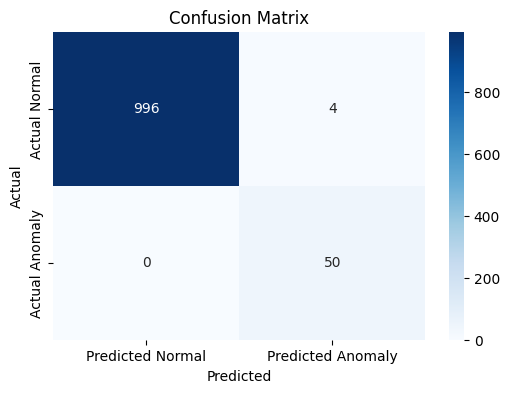

In [5]:
# Ensure we have the results and the required columns
if 'df_results' not in locals() or df_results is None:
     raise SystemExit("Prediction results are not available for evaluation.")
if 'CLUSTER_ID' not in df_results.columns:
     raise SystemExit("Required 'CLUSTER_ID' column not found in prediction results for evaluation.")

# Merge predictions with the original local data (which has the ground truth)
print("\nMerging predictions with ground truth...")
df_merged = pd.merge(df_local[[KEY_COL, TRUTH_COL]], df_results, on=KEY_COL)

# DBSCAN's CLUSTER_ID is -1 for outliers and >= 0 for inliers.
# Our ground truth TRUTH_COL is 1 for anomalies (outliers) and 0 for normal (inliers).
# Map the predicted CLUSTER_ID to match the ground truth format (0 or 1).
df_merged['predicted_anomaly'] = df_merged['CLUSTER_ID'].apply(lambda x: 1 if x == -1 else 0)

print("\nMerged DataFrame Head (with truth and prediction):")
# Display relevant columns: ID, ground truth, cluster ID, distance, mapped prediction (0/1)
print(df_merged[[KEY_COL, TRUTH_COL, 'CLUSTER_ID', 'DISTANCE', 'predicted_anomaly']].head())

# --- Performance Metrics ---
print("\n--- Classification Report ---")
# Compare ground truth (is_anomaly) with the mapped prediction (predicted_anomaly)
print(classification_report(df_merged[TRUTH_COL], df_merged['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(df_merged[TRUTH_COL], df_merged['predicted_anomaly'])
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



--- Visualizing Predictions vs. Ground Truth ---

Generating pair plot for prediction analysis...


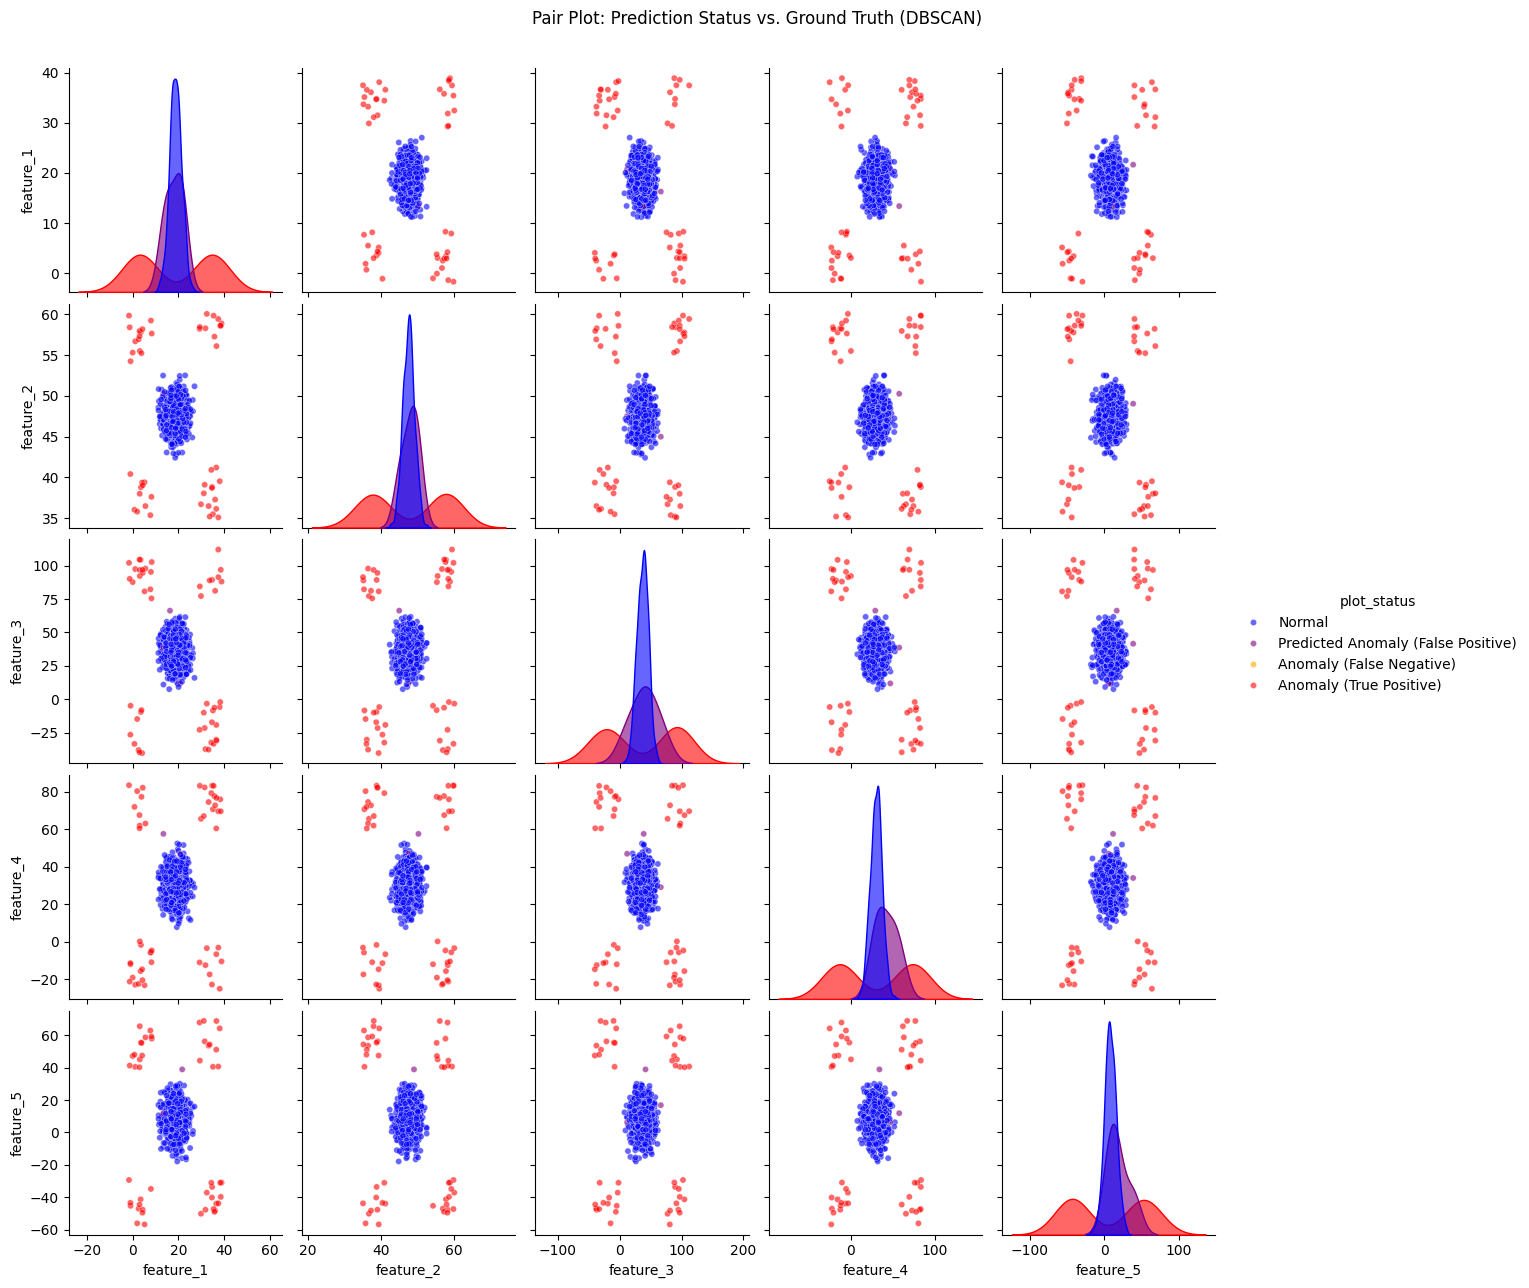

In [6]:
# --- Prediction Visualization (Pair Plot) ---
print("\n--- Visualizing Predictions vs. Ground Truth ---")

# Define a function to map status based on truth and prediction
def assign_plot_status(row):
    if row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 0:
        return 'Normal'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 1:
        return 'Anomaly (True Positive)'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 0:
        return 'Anomaly (False Negative)' # Missed by model
    elif row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 1:
        return 'Predicted Anomaly (False Positive)' # Incorrectly flagged
    else:
        return 'Unknown'

# Apply the function to create the status column in the merged dataframe
df_merged['plot_status'] = df_merged.apply(assign_plot_status, axis=1)

# Add the features from df_local to df_merged
# Ensure feature columns are present for pairplot
df_merged = df_merged.join(df_local[feature_cols])

# Define a color palette for the statuses
status_palette = {
    'Normal': 'blue',
    'Anomaly (True Positive)': 'red',
    'Anomaly (False Negative)': 'orange',
    'Predicted Anomaly (False Positive)': 'purple'
}

# Generate the pair plot
try:
    print("\nGenerating pair plot for prediction analysis...")
    # Use only feature columns for the plot axes
    pair_plot_preds = sns.pairplot(df_merged, 
                                   vars=feature_cols, 
                                   hue='plot_status', 
                                   palette=status_palette,
                                   diag_kind='kde',
                                   plot_kws={'alpha': 0.6, 's': 20}, 
                                   diag_kws={'alpha': 0.6, 'common_norm': False}, # Use common_norm=False for KDE
                                   hue_order=['Normal', 'Predicted Anomaly (False Positive)', 'Anomaly (False Negative)', 'Anomaly (True Positive)'] # Control legend order
                                  )
    pair_plot_preds.fig.suptitle('Pair Plot: Prediction Status vs. Ground Truth (DBSCAN)', y=1.03) # Add title
    plt.show()
except Exception as e:
    print(f"\nCould not generate prediction pair plot. Error: {e}")

## 5. Using `fit_predict()`

The `DBSCAN` class also offers a convenience method `fit_predict()` that combines training and prediction in a single step. For DBSCAN, `fit_predict` returns only the cluster labels.

In [7]:
# Instantiate a new model or reuse, but fit_predict will overwrite internal model state
dbscan_fp = DBSCAN(
    minpts=None, # Let PAL determine
    eps=None,    # Let PAL determine
    thread_ratio=1
)

print("\nUsing fit_predict()...")

try:
    # fit_predict returns the labels DataFrame (ID, CLUSTER_ID)
    results_fp_hdf = dbscan_fp.fit_predict(
        data=hdf_input,
        key=KEY_COL,
        features=feature_cols
    )

    print("fit_predict completed.")

    if results_fp_hdf:
        print("\nfit_predict Results (HANA DataFrame Head):")
        df_results_fp = results_fp_hdf.collect()
        print(df_results_fp.head())

        # You could perform the same evaluation steps as above on df_results_fp
        # Merging, mapping labels, calculating metrics...
    else:
        print("fit_predict did not return a results DataFrame.")


except Exception as e:
    print(f"Error during fit_predict: {e}")
    raise SystemExit("fit_predict failed.")

# Compare if results from fit() -> predict() are same as fit_predict()
# Note: predict() returns ID, CLUSTER_ID, DISTANCE, while fit_predict() returns ID, CLUSTER_ID.
#       We can compare the CLUSTER_ID columns.
if 'df_results' in locals() and 'df_results_fp' in locals():
     # Sort by ID to ensure correct comparison row-by-row
     df_results_sorted = df_results.sort_values(by=KEY_COL).reset_index(drop=True)
     df_results_fp_sorted = df_results_fp.sort_values(by=KEY_COL).reset_index(drop=True)

     # Compare only the ID and CLUSTER_ID columns
     comparison = df_results_sorted[[KEY_COL, 'CLUSTER_ID']].equals(df_results_fp_sorted[[KEY_COL, 'CLUSTER_ID']])
     print(f"\nAre CLUSTER_IDs from predict() and fit_predict() identical? {comparison}")


Using fit_predict()...
fit_predict completed.

fit_predict Results (HANA DataFrame Head):
   ID  CLUSTER_ID
0   0           0
1   1           0
2   2           0
3   3           0
4   4           0

Are CLUSTER_IDs from predict() and fit_predict() identical? False


In [8]:
# Find the differences between df_results_sorted[[KEY_COL, 'CLUSTER_ID']] and df_results_fp_sorted[[KEY_COL, 'CLUSTER_ID']]
if not comparison:
    # Merge to find differences
    merged_results = pd.merge(
        df_results_sorted[[KEY_COL, 'CLUSTER_ID']],
        df_results_fp_sorted[[KEY_COL, 'CLUSTER_ID']],
        on=KEY_COL,
        suffixes=('_predict', '_fit_predict')
    )

    # Find rows where CLUSTER_IDs differ
    differences = merged_results[merged_results['CLUSTER_ID_predict'] != merged_results['CLUSTER_ID_fit_predict']]
    print("\nDifferences between predict() and fit_predict():")
    print(differences)


Differences between predict() and fit_predict():
      ID  CLUSTER_ID_predict  CLUSTER_ID_fit_predict
622  622                   0                      -1


## 6. Cleanup

Finally, let's remove the table we created in HANA.

In [9]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_ANOMALY_DATA_DBSCAN

HANA connection closed.
